# Install libraries

In [ ]:
# !pip install pyspark
# !pip install missingno
# !pip install squarify
# !pip install geopy
# !pip install geocoder
# !pip install neo4j


# Import libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp,col,lit, regexp_replace, to_date, unix_timestamp
import pandas as pd
from pyspark.sql.types import *
import missingno as msno
from sklearn.model_selection import train_test_split
from geopy.geocoders import Nominatim
import plotly.express as px
import time

from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.pyplot as plt
import squarify
import seaborn as sns
import numpy as np
from matplotlib.dates import DateFormatter, DayLocator

from pyspark.sql.functions import from_unixtime
from pyspark.sql.functions import col

from neo4j import GraphDatabase

from pyspark import SparkContext
from pyspark.sql import SQLContext
from functools import reduce
import pyspark.sql.functions as F
from io import StringIO

# Setup Spark

In [2]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

# Get Data

## Data sources

In [3]:
base_url = "https://raw.githubusercontent.com/ZanZver/BigDataManagement/main/Data/"
chat_data = "chat-data/"
flamingo_data = "flamingo-data/"
data_sources = {
  "chat-join-team-chat": f"{base_url}{chat_data}chat_join_team_chat.csv",
  "chat-leave-team-chat": f"{base_url}{chat_data}chat_leave_team_chat.csv",
  "chat-mention-team-chat": f"{base_url}{chat_data}chat_mention_team_chat.csv",
  "chat-respond-team-chat": f"{base_url}{chat_data}chat_respond_team_chat.csv",
  "ad-clicks": f"{base_url}{flamingo_data}ad-clicks.csv",
  "buy-clicks": f"{base_url}{flamingo_data}buy-clicks.csv",
  "game-clicks": f"{base_url}{flamingo_data}game-clicks.csv",
  "level-events": f"{base_url}{flamingo_data}level-events.csv",
  "team-assignments": f"{base_url}{flamingo_data}team-assignments.csv",
  "team": f"{base_url}{flamingo_data}team.csv",
  "user-session": f"{base_url}{flamingo_data}user-session.csv",
  "users": f"{base_url}{flamingo_data}users.csv",
  "combined-data": f"{base_url}combined-data.csv",
}

## Load the data

In [4]:
data_loaded = {
  "chat_join_team_chat_pd": pd.read_csv(data_sources["chat-join-team-chat"]),
  "chat_leave_team_chat_pd": pd.read_csv(data_sources["chat-leave-team-chat"]),
  "chat_mention_team_chat_pd": pd.read_csv(data_sources["chat-mention-team-chat"]),
  "chat_respond_team_chat_pd": pd.read_csv(data_sources["chat-respond-team-chat"]),
  "ad_clicks_pd": pd.read_csv(data_sources["ad-clicks"]),
  "buy_clicks_pd": pd.read_csv(data_sources["buy-clicks"]),
  "game_clicks_pd": pd.read_csv(data_sources["game-clicks"]),
  "level_events_pd": pd.read_csv(data_sources["level-events"]),
  "team_assignments_pd": pd.read_csv(data_sources["team-assignments"]),
  "team_pd": pd.read_csv(data_sources["team"]),
  "user_session_pd": pd.read_csv(data_sources["user-session"]),
  "users_pd": pd.read_csv(data_sources["users"]),
  "combined_data_pd": pd.read_csv(data_sources["combined-data"]),
}

### Date transformation

In [5]:
def convert_date_time_to_unix(data_frame):
    data_frame = pd.to_datetime(data_frame, format='%Y-%m-%d %H:%M:%S')
    data_frame = data_frame.astype(int) // 10**9
    return data_frame

def convert_date_to_unix(data_frame):
    data_frame = pd.to_datetime(data_frame, format='%Y-%m-%d %H:%M:%S')
    data_frame = data_frame.astype(int) // 10**9
    return data_frame

data_frames = ["ad_clicks_pd", "buy_clicks_pd", "game_clicks_pd", "level_events_pd", "team_assignments_pd", 
               "team_pd", "user_session_pd", "users_pd"]
for df_name in data_frames:
    if df_name == "team_pd":
        data_loaded[df_name]["teamEndTime"] = data_loaded[df_name]["teamEndTime"].replace('9999-12-31 23:59:59', "2038-01-19 03:14:07")
        data_loaded[df_name]["teamEndTime"] = convert_date_time_to_unix(data_loaded[df_name]["teamEndTime"])
        data_loaded[df_name]["teamCreationTime"] = convert_date_time_to_unix(data_loaded[df_name]["teamCreationTime"])
    else:
        data_loaded[df_name]["timestamp"] = convert_date_time_to_unix(data_loaded[df_name]["timestamp"])
        
data_loaded["users_pd"]["dob"] = convert_date_time_to_unix(data_loaded["users_pd"]["dob"])


## EDA

### Functions

In [6]:
def convert_unix_to_datetime(data_frame, column_name):
    # Check if the column is already a datetime type or is null
    if pd.api.types.is_datetime64_any_dtype(data_frame[column_name]) or pd.isnull(data_frame[column_name]).all():
        return data_frame
    
    data_frame = data_frame.copy()
    # Convert Unix time to datetime object
    data_frame[column_name] = pd.to_datetime(data_frame[column_name], unit='s', errors='coerce')
    
    # Set null values to Unix 32-bit maximum value
    #data_frame[column_name] = data_frame[column_name].fillna(pd.Timestamp(np.datetime64('2038-01-19 03:14:07')))
    
    # Return the updated dataframe
    return data_frame

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator

def generate_timeseries_plot(data_frame, col_1, x_label, y_label, title, file_Path):
    
    # Convert the 'created_utc' column to datetime
    data_frame = convert_unix_to_datetime(data_frame[[col_1]], col_1)

    # Group the data by month and count the number of posts per month
    counts = data_frame.groupby(pd.Grouper(key=col_1, freq='D')).size()

    # Create a figure and axis
    fig, ax = plt.subplots()
    plt.xticks(rotation=90)

    # Plot the data as a line chart
    ax.plot(counts.index, counts.values)

    # Set the x-axis ticks to show every 4 months
    ax.xaxis.set_major_locator(MonthLocator(interval=4))

    # Set the x-axis tick labels to display the month and year
    ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))

    # Set the axis labels
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Set the title
    ax.set_title(title)

    # Save the figure to the specified file path
    plt.savefig(file_Path)

    # Close the figure to free up resources
    plt.close(fig)

def count_occurrences(items):
    # initialize an empty dictionary to store the counts
    counts = {}
    
    # loop through the items
    for item in items:
        # check if the item is already in the dictionary
        if item in counts:
            # if it is, increment the count by 1
            counts[item] += 1
        else:
            # if it's not, add it to the dictionary with a count of 1
            counts[item] = 1
    
    # convert the dictionary to a DataFrame
    df_counts = pd.DataFrame(list(counts.items()), columns=['item', 'count'])
    
    # return the DataFrame
    return df_counts

def generate_tree_map(data_frame, item_1, item_2, item_1_txt, item_2_txt, title, file_Path):
    def format_label(item_1_val, item_2_val):
        return f"{item_1_txt}:\n{item_1_val}\n{item_2_txt}:\n{item_2_val}"

    squarify.plot(sizes=data_frame[item_1], 
                label=[format_label(item_1, item_2) for item_1, item_2 
                        in zip(data_frame[item_1], data_frame[item_2])],
                color=sns.color_palette("pastel", len(data_frame)))

    # Save the treemap to the specified file path
    plt.savefig(file_Path)

    # Close the figure to free up resources
    plt.close()
    
def create_ad_graph(data_frame, file_Path):
    adIds_1 = data_frame["adId"]
    adCategories_1 = data_frame["adCategory"]

    # Create a dictionary to store the number of occurrences for each adCategory
    categories_count = {}
    for category in adCategories_1:
        if category not in categories_count:
            categories_count[category] = 0
        categories_count[category] += 1
    
    # Create a list of colors to use for each adCategory
    colors = []
    for category in adCategories_1:
        colors.append('C' + str(list(categories_count.keys()).index(category)))
    
    # Create a dictionary to store the handles and labels for each adCategory
    handles = {}
    for category in categories_count:
        index = list(categories_count.keys()).index(category)
        handles[category] = plt.scatter([], [], c='C' + str(index), label=category)
    
    # Create the scatter plot and legend
    plt.scatter(adIds_1, adCategories_1, c=colors)
    plt.xlabel('adId')
    plt.ylabel('adCategory')
    plt.legend(handles=handles.values(), labels=handles.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

    # Save the scatter plot to the specified file path
    plt.savefig(file_Path)

    # Close the figure to free up resources
    plt.close()

def create_histogram(column, num_show, file_Path):
    # create histogram data
    hist_data = column.value_counts().sort_values(ascending=False).head(num_show)

    # create histogram
    hist = hist_data.plot(kind='bar', width=0.8)

    # customize plot
    plt.xlabel('Team ID')
    plt.ylabel('Count')
    plt.title('Team IDs Histogram')

    # Save the histogram plot to the specified file path
    plt.savefig(file_Path)

    # Close the figure to free up resources
    plt.close()


def create_correlation_plot(data_frame, file_Path):
    # create correlation plot
    corr = data_frame.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')

    # Save the correlation plot to the specified file path
    plt.savefig(file_Path)

    # Close the figure to free up resources
    plt.close()


def create_pie_chart(data_frame, file_Path):
    # create pie chart data
    pie_data = data_frame.value_counts()

    # create pie chart
    fig, ax = plt.subplots()
    ax.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%')

    # customize plot
    ax.set_title('Platform Type Distribution')

    # Save the pie chart to the specified file path
    plt.savefig(file_Path)

    # Close the figure to free up resources
    plt.close()


def create_multi_graph(data_frame, file_Path):
    # group data by platformType and calculate the sum of game clicks and hits
    grouped_data = data_frame.groupby('platformType').sum()

    # create grouped bar chart
    x_labels = grouped_data.index.values
    x = np.arange(len(x_labels))
    width = 0.35
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, grouped_data['count_gameclicks'], width, label='Game Clicks')
    rects2 = ax.bar(x + width/2, grouped_data['count_hits'], width, label='Hits')

    # customize plot
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_ylabel('Counts')
    ax.set_title('Counts by Platform Type')
    ax.legend()

    # Save the grouped bar chart to the specified file path
    plt.savefig(file_Path)

    # Close the figure to free up resources
    plt.close()


def create_price_histogram(data_frame, file_Path):
    # group data by platformType and calculate the average price
    grouped_data = data_frame.groupby('platformType').mean()

    # create bar chart
    x_labels = grouped_data.index.values
    x = np.arange(len(x_labels))
    fig, ax = plt.subplots()
    ax.bar(x, grouped_data['avg_price'])

    # customize plot
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_ylabel('Average Price')
    ax.set_title('Average Price by Platform Type')

    # Save the bar chart to the specified file path
    plt.savefig(file_Path)

    # Close the figure to free up resources
    plt.close()

    
def generate_timeseries_plot_2(data_frame, col_1, col_2, x_label, y_label, title, file_Path):
    # Convert the 'created_utc' column to datetime
    data_frame_1 = convert_unix_to_datetime(data_frame[[col_1]], col_1)
    data_frame_2 = convert_unix_to_datetime(data_frame[[col_2]], col_2)

    # Remove rows that contain datetime value '2038-01-19 03:14:07' in data_frame_1
    data_frame_1 = data_frame_1[data_frame_1[col_1] != pd.to_datetime('2038-01-19 03:14:07')]

    # Remove rows that contain datetime value '2038-01-19 03:14:07' in data_frame_2
    data_frame_2 = data_frame_2[data_frame_2[col_2] != pd.to_datetime('2038-01-19 03:14:07')]

    # Group the data by day and count the number of posts per day
    counts_1 = data_frame_1.groupby(pd.Grouper(key=col_1, freq='D')).size()
    counts_2 = data_frame_2.groupby(pd.Grouper(key=col_2, freq='D')).size()

    # Create a figure and axis
    fig, ax = plt.subplots()
    plt.xticks(rotation=90)

    # Plot the data as a line chart
    ax.plot(counts_1.index, counts_1.values)
    ax.plot(counts_2.index, counts_2.values, dashes=[4, 4])

    # Set the x-axis ticks to show every day
    ax.xaxis.set_major_locator(DayLocator())

    # Set the x-axis tick labels to display the month and year
    ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))

    # Set the axis labels
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Set the title
    ax.set_title(title)

    # Save the plot to a file
    fig.savefig(file_Path)
    plt.close(fig)


def create_team_strength(data_frame, x_lab, y_lab, file_Path, asc=False, lim=20):
    # sort, then reset index
    data_frame = data_frame.sort_values('strength', ascending=asc).reset_index(drop=True).head(lim)

    ax = sns.pointplot(x=data_frame.index, y=data_frame.strength)
    ax.set_xlabel(x_lab)
    ax.set_ylabel(y_lab)

    # Use name column to label x ticks
    _ = ax.set_xticklabels(data_frame.teamId.astype(str).values)

    # Save the point plot to the specified file path
    plt.savefig(file_Path)

    # Close the figure to free up resources
    plt.close()


def create_histogram_session(data_frame, file_Path):
    # group the data by sessionType and platformType, and count the occurrences
    grouped = data_frame.groupby(['sessionType', 'platformType']).size().unstack()

    # create a stacked bar chart
    grouped.plot(kind='bar', stacked=True)

    # set the x-axis label
    plt.xlabel('Platform Type')

    # set the y-axis label
    plt.ylabel('Count')

    # set the title
    plt.title('Session Status by Platform Type')

    # save the stacked bar chart to the specified file path
    plt.savefig(file_Path)

    # close the figure to free up resources
    plt.close()


def create_dob_histogram(data_frame, file_Path):
    # Sample data
    data = {'dob': data_frame}
    df = pd.DataFrame(data)

    # Convert dob to datetime object
    df['dob'] = pd.to_datetime(df['dob'])

    # Extract year from dob
    df['year'] = df['dob'].dt.year

    # Create histogram
    plt.hist(df['year'], bins=10)
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.title('Histogram of Birth Years')

    # Save the histogram plot to the specified file path
    plt.savefig(file_Path)

    # Close the figure to free up resources
    plt.close()


def prepare_the_countries():
    tmp_data = data_loaded["users_pd"]["country"].to_list()
    tmp_data = [str(x) for x in tmp_data]
    return [x for x in tmp_data if x != 'nan']

def create_world_map():
    # Sample data
    data = {'country': prepare_the_countries()}
    df = pd.DataFrame(data)

    # Initialize geolocator
    geolocator = Nominatim(user_agent="big_data_application")#, timeout=10)

    # Define function to get latitude and longitude from country name
    def get_lat_lon(country):
        try:
          #time.sleep(20)
          location = geolocator.geocode(country)
          return (location.latitude, location.longitude)
        except:
          return (42.1368853, 13.610341022538911)

    # Add the latitude and longitude to the dataframe
    df['lat'], df['lon'] = zip(*df['country'].apply(get_lat_lon))

    # Create dictionary of counts for each country
    counts = df['country'].value_counts().to_dict()

    # Create list of circle sizes for each country
    sizes = [1 * counts[c] for c in df['country']]

    # Create map graph
    fig = px.scatter_geo(df, lat='lat', lon='lon', color='country', size=sizes)
    fig.update_layout(title='Map of Countries')
    fig.show()


### ad clicks

In [7]:
data_loaded["ad_clicks_pd"].head()

,timestamp,txId,userSessionId,teamId,userId,adId,adCategory
0,1464275602,5974,5809,27,611,2,electronics
1,1464275844,5976,5705,18,1874,21,movies
2,1464276172,5978,5791,53,2139,25,computers
3,1464276177,5973,5756,63,212,10,fashion
4,1464276178,5980,5920,9,1027,20,clothing


<AxesSubplot:>

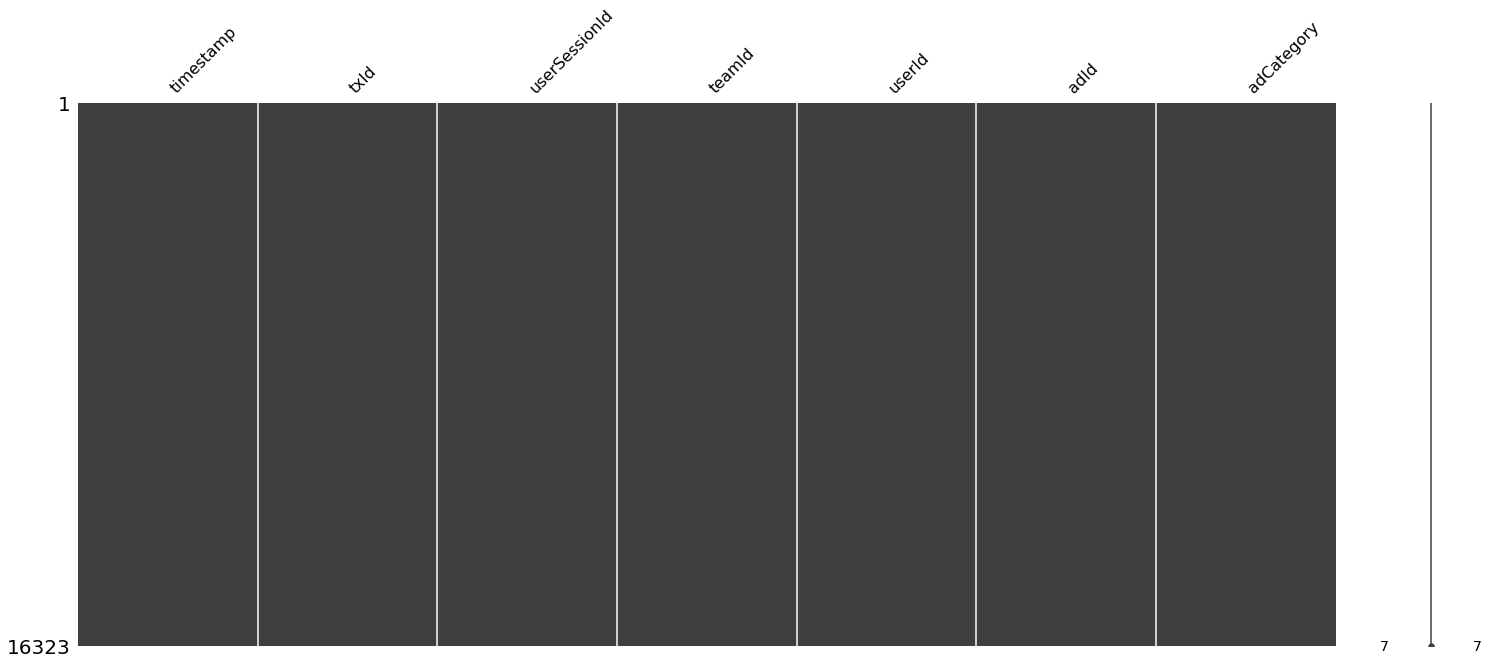

In [8]:
msno.matrix(data_loaded["ad_clicks_pd"])

In [9]:
generate_timeseries_plot(data_frame = data_loaded["ad_clicks_pd"], 
                         col_1="timestamp", 
                         x_label = "Date", 
                         y_label = "Test", 
                         title = "Over time", 
                         file_Path = "Graphs/adClicks/timeseries_adClicks.png")

In [10]:
generate_tree_map(count_occurrences(data_loaded["ad_clicks_pd"]["teamId"]).\
                  sort_values(by=['count'], ascending=False).head(10),
                  item_1 = "count",
                  item_2 = "item",
                  item_1_txt= "count",
                  item_2_txt= "item", 
                  title = "Item vs count",
                  file_Path = "Graphs/adClicks/tree_map_adClicks.png")

In [11]:
create_ad_graph(data_frame = data_loaded["ad_clicks_pd"][["adId","adCategory"]],
                file_Path = "Graphs/adClicks/create_ad_adClicks.png")

### buy clicks

In [12]:
data_loaded["buy_clicks_pd"].head()

,timestamp,txId,userSessionId,team,userId,buyId,price
0,1464277014,6004,5820,9,1300,2,3.0
1,1464277014,6005,5775,35,868,4,10.0
2,1464277014,6006,5679,97,819,5,20.0
3,1464280614,6067,5665,18,121,2,3.0
4,1464282414,6093,5709,11,2222,5,20.0


<AxesSubplot:>

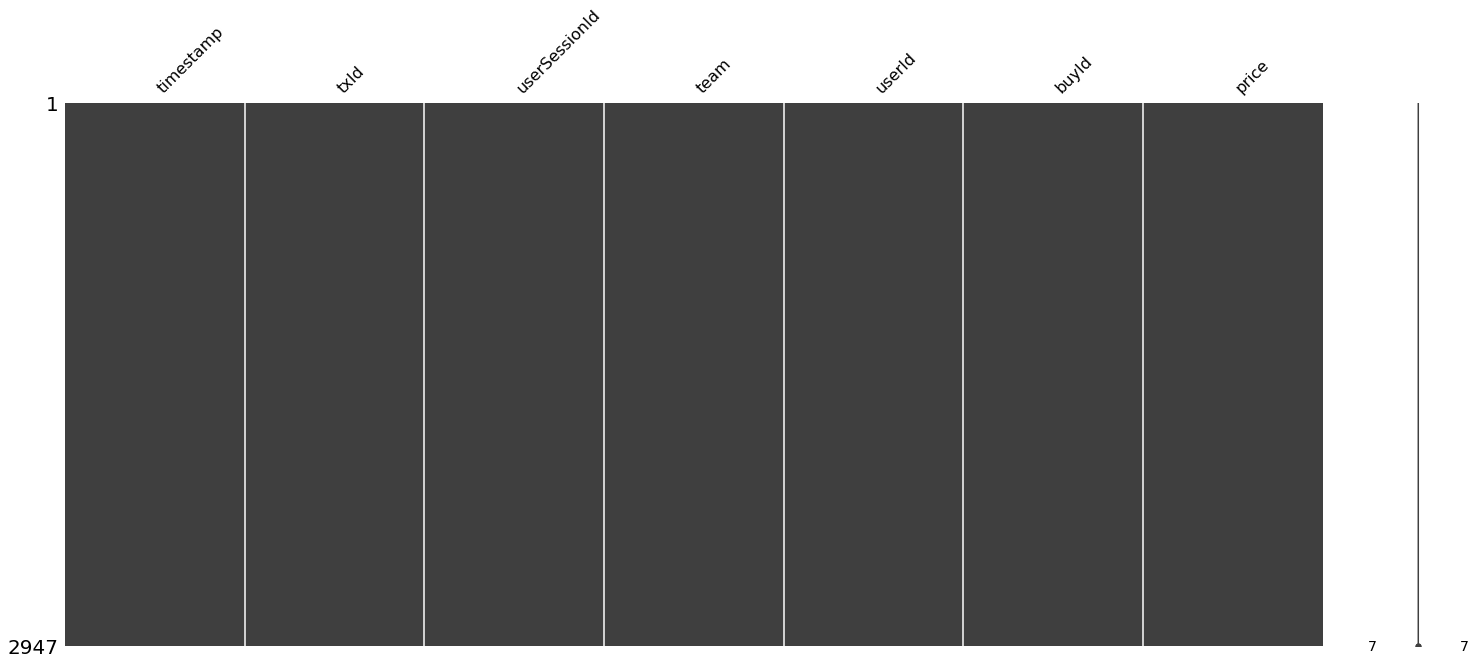

In [13]:
msno.matrix(data_loaded["buy_clicks_pd"])

In [14]:
generate_timeseries_plot(data_frame = data_loaded["buy_clicks_pd"], 
                         col_1="timestamp", 
                         x_label = "Date", 
                         y_label = "Test", 
                         title = "Over time",
                         file_Path = "Graphs/buyClicks/timeseries_buyClicks.png")

In [15]:
create_histogram(column = data_loaded["buy_clicks_pd"]["team"], 
                 num_show=20,
                 file_Path = "Graphs/buyClicks/histogram_buyClicks.png")

In [16]:
create_correlation_plot(data_frame = data_loaded["buy_clicks_pd"][["team","buyId", "price"]],
                        file_Path = "Graphs/buyClicks/correlationPlot_buyClicks.png")

### combined data

In [17]:
data_loaded["combined_data_pd"].head()

,userId,userSessionId,teamLevel,platformType,count_gameclicks,count_hits,count_buyId,avg_price
0,812,5648,1,android,69,8,NaN,NaN
1,1658,5649,1,iphone,31,5,NaN,NaN
2,1589,5650,1,iphone,26,2,NaN,NaN
3,1863,5651,1,android,35,4,NaN,NaN
4,937,5652,1,android,39,0,1.0,1.0


<AxesSubplot:>

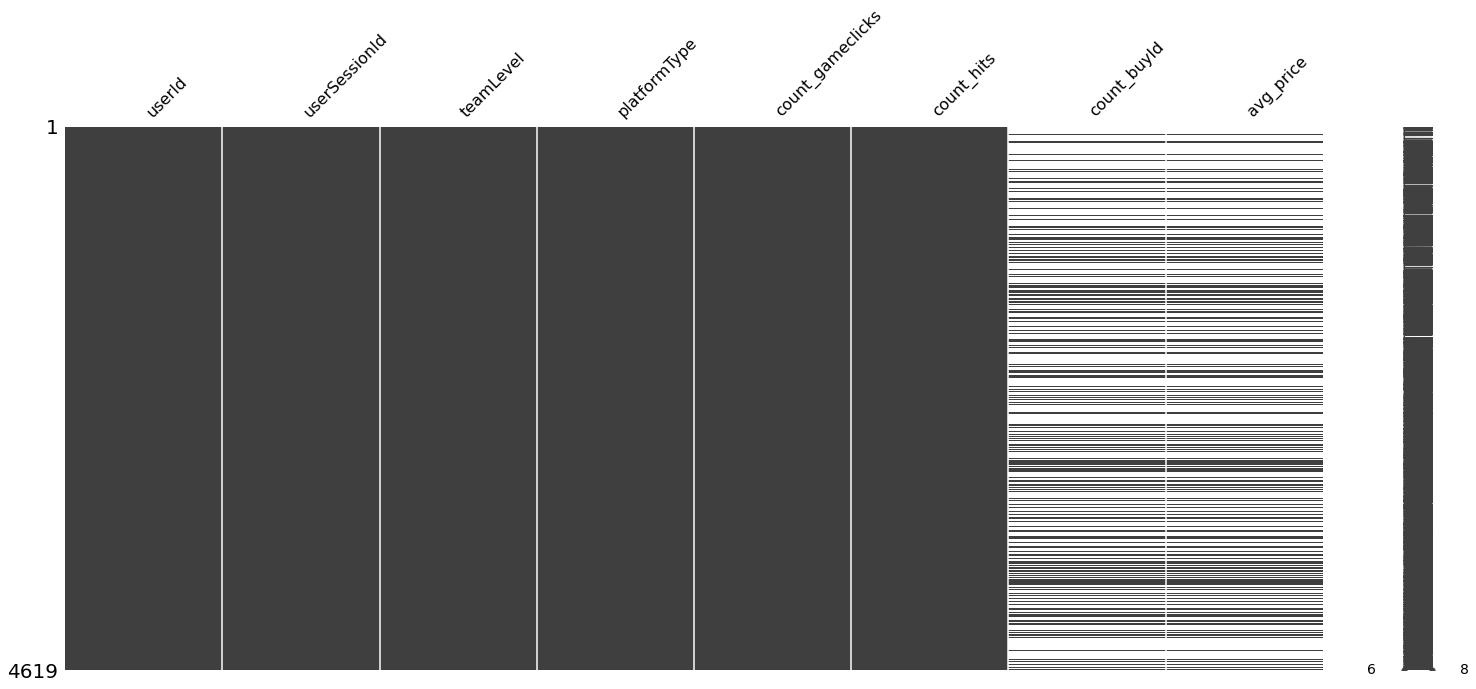

In [18]:
msno.matrix(data_loaded["combined_data_pd"])

In [19]:
create_pie_chart(data_frame = data_loaded["combined_data_pd"]["platformType"],
                 file_Path = "Graphs/combinedData/correlationPlot_buyClicks.png")

In [20]:
create_multi_graph(data_frame=data_loaded["combined_data_pd"][["platformType","count_gameclicks","count_hits"]],
                   file_Path = "Graphs/combinedData/multiGrap_buyClicks.png")

In [21]:
create_price_histogram(data_frame=data_loaded["combined_data_pd"][["platformType","avg_price"]],
                       file_Path = "Graphs/combinedData/priceHistogram_buyClicks.png")

### game clicks

In [22]:
data_loaded["game_clicks_pd"].head()

,timestamp,clickId,userId,userSessionId,isHit,teamId,teamLevel
0,1464275215,105,1038,5916,0,25,1
1,1464275229,154,1099,5898,0,44,1
2,1464275234,229,899,5757,0,71,1
3,1464275234,322,2197,5854,0,99,1
4,1464275240,22,1362,5739,0,13,1


<AxesSubplot:>

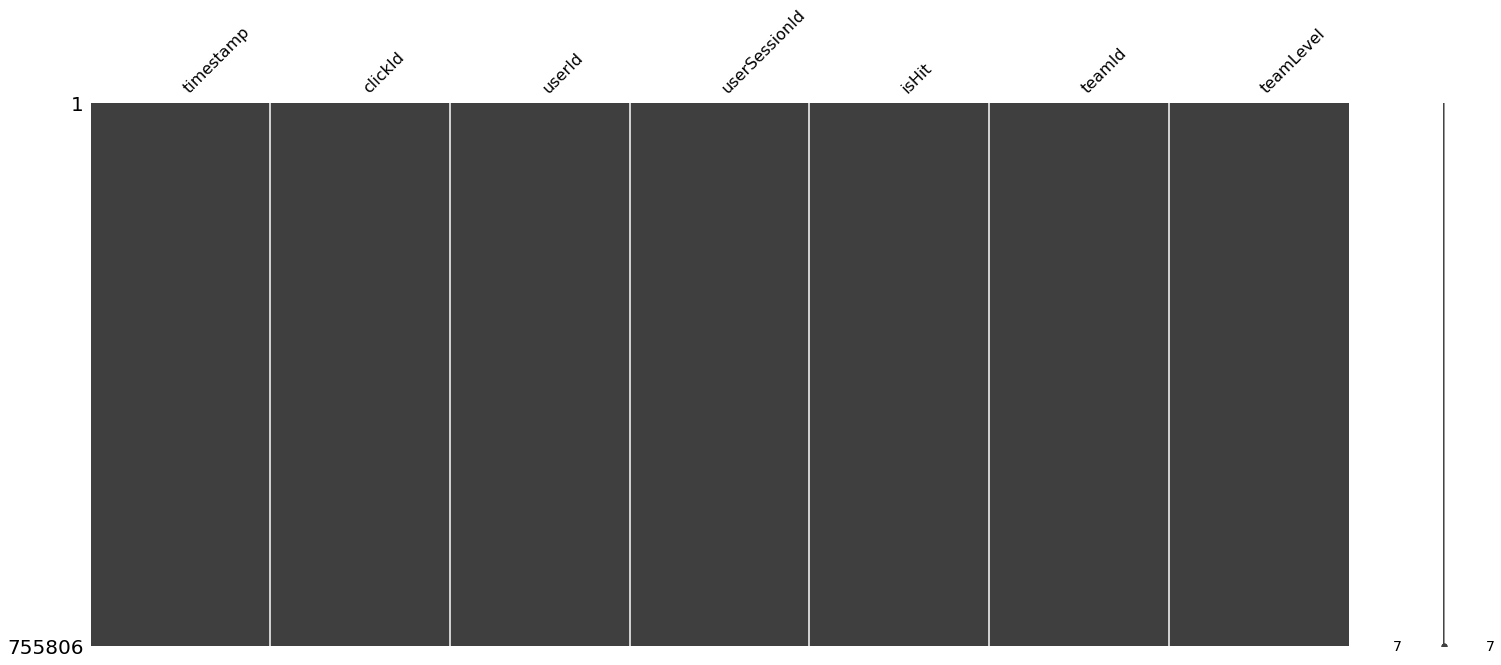

In [23]:
msno.matrix(data_loaded["game_clicks_pd"])

In [24]:
generate_timeseries_plot(data_frame = data_loaded["game_clicks_pd"], 
                         col_1="timestamp", 
                         x_label = "Date", 
                         y_label = "Test", 
                         title = "Over time",
                         file_Path = "Graphs/gameClicks/timeseries_gameClicks.png")

### level events

In [25]:
data_loaded["level_events_pd"].head()

,timestamp,eventId,teamId,teamLevel,eventType
0,1464390414,0,2,1,end
1,1464390414,1,2,2,start
2,1464390414,2,8,1,end
3,1464390414,3,8,2,start
4,1464390414,4,9,1,end


<AxesSubplot:>

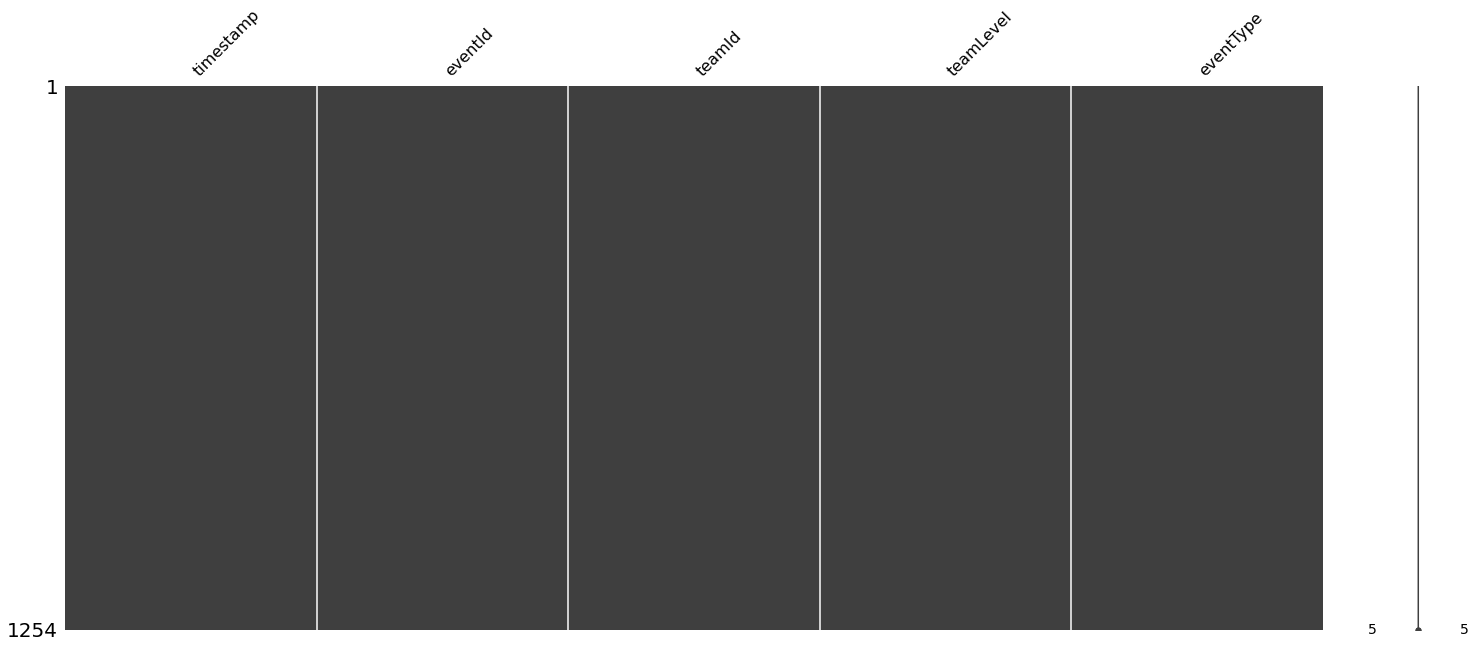

In [26]:
msno.matrix(data_loaded["level_events_pd"])

In [27]:
generate_timeseries_plot(data_frame = data_loaded["level_events_pd"], 
                         col_1="timestamp", 
                         x_label = "Date", 
                         y_label = "Test", 
                         title = "Over time",
                         file_Path = "Graphs/levelEvents/timeseries_levelEvents.png")

### team assignments

In [28]:
data_loaded["team_assignments_pd"].head()

,timestamp,team,userId,assignmentId
0,1464271614,64,504,5439
1,1464271620,39,1698,5301
2,1464271624,85,81,5540
3,1464271628,95,1976,5307
4,1464271629,97,1009,5368


<AxesSubplot:>

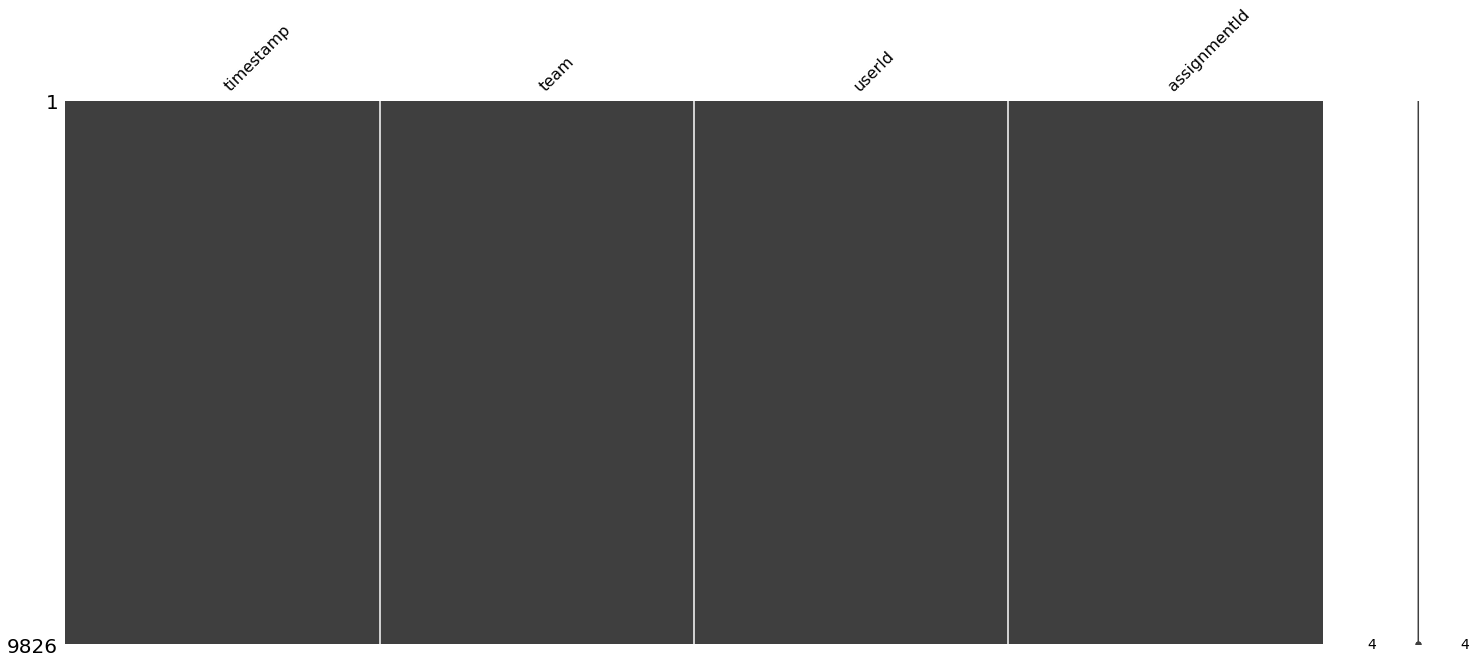

In [29]:
msno.matrix(data_loaded["team_assignments_pd"])

In [30]:
generate_timeseries_plot(data_frame = data_loaded["team_assignments_pd"], 
                         col_1="timestamp", 
                         x_label = "Date", 
                         y_label = "Test", 
                         title = "Over time",
                         file_Path = "Graphs/teamAssignments/timeseries_teamAssignments.png")

### team

In [31]:
data_loaded["team_pd"].head()

,teamId,name,teamCreationTime,teamEndTime,strength,currentLevel
0,79,O1uJX7C,1465745607,2147483647,0.774474,1
1,92,WeLHp8HZ,1465768460,2147483647,0.171926,1
2,6,mARlfz,1465772536,2147483647,0.537353,1
3,7,xO41jlAo0Y,1465797783,2147483647,0.394370,1
4,40,vdwO0k1,1465801263,2147483647,0.706833,1


<AxesSubplot:>

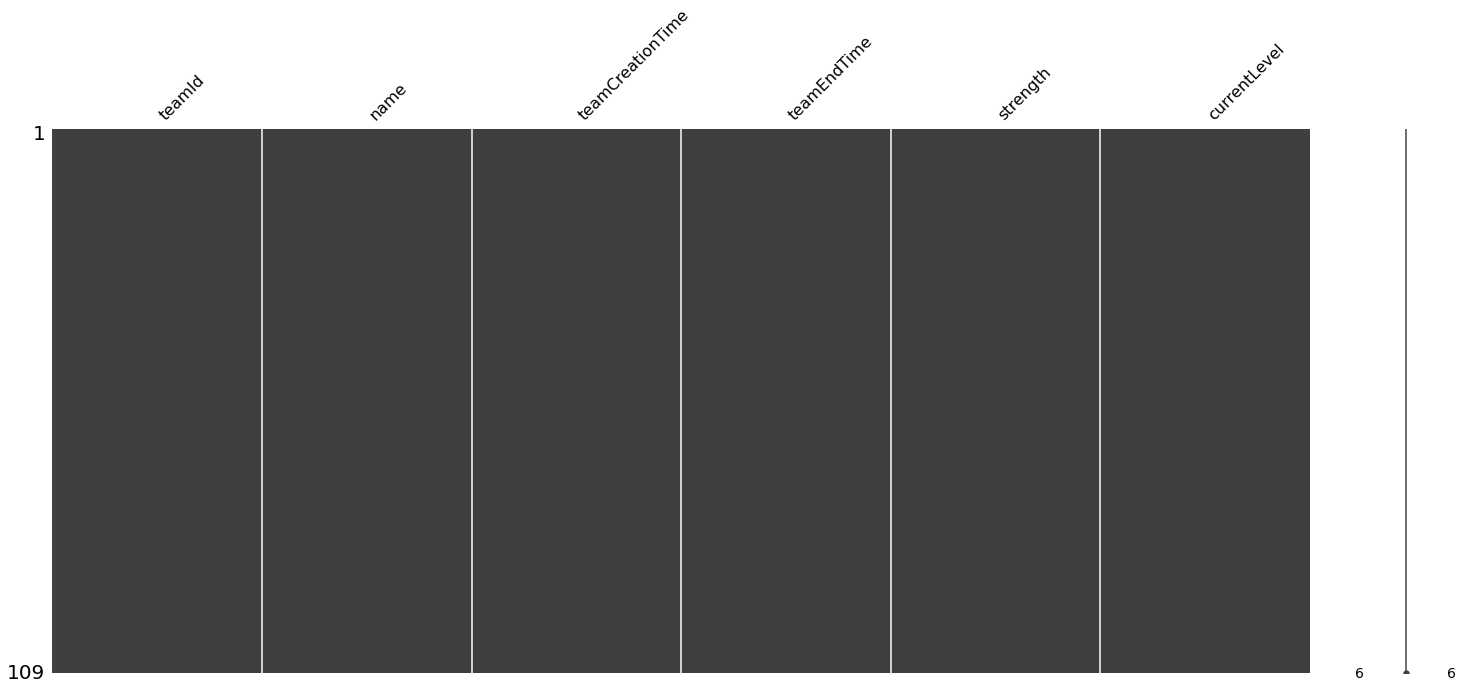

In [32]:
msno.matrix(data_loaded["team_pd"])

In [33]:
generate_timeseries_plot(data_frame = data_loaded["team_pd"], 
                         col_1="teamCreationTime", 
                         x_label = "Date", 
                         y_label = "Test", 
                         title = "Over time",
                         file_Path = "Graphs/team/timeseries_team.png")

In [34]:
generate_timeseries_plot_2(data_frame = data_loaded["team_pd"], 
                           col_1="teamCreationTime", 
                           col_2="teamEndTime", 
                           x_label = "Date", 
                           y_label = "Test", 
                           title = "Over time",
                           file_Path = "Graphs/team/timeseries2_team.png")

In [35]:
create_team_strength(data_frame=data_loaded["team_pd"], 
                     x_lab="Team ID", 
                     y_lab="Strength",
                     file_Path = "Graphs/team/teamSstrength_team.png")

In [36]:
create_team_strength(data_frame=data_loaded["team_pd"], 
                     x_lab="Team ID", 
                     y_lab="Strength",
                     file_Path = "Graphs/team/teamSstrength_team2.png",
                     asc = True)

### user session

In [37]:
data_loaded["user_session_pd"].head()

,timestamp,userSessionId,userId,teamId,assignmentId,sessionType,teamLevel,platformType
0,1464274050,5675,170,90,5423,start,1,iphone
1,1464307614,5675,170,90,5423,end,1,iphone
2,1464273789,5795,835,39,5300,start,1,android
3,1464336414,5795,835,39,5300,end,1,android
4,1464274040,5833,624,2,5529,start,1,iphone


<AxesSubplot:>

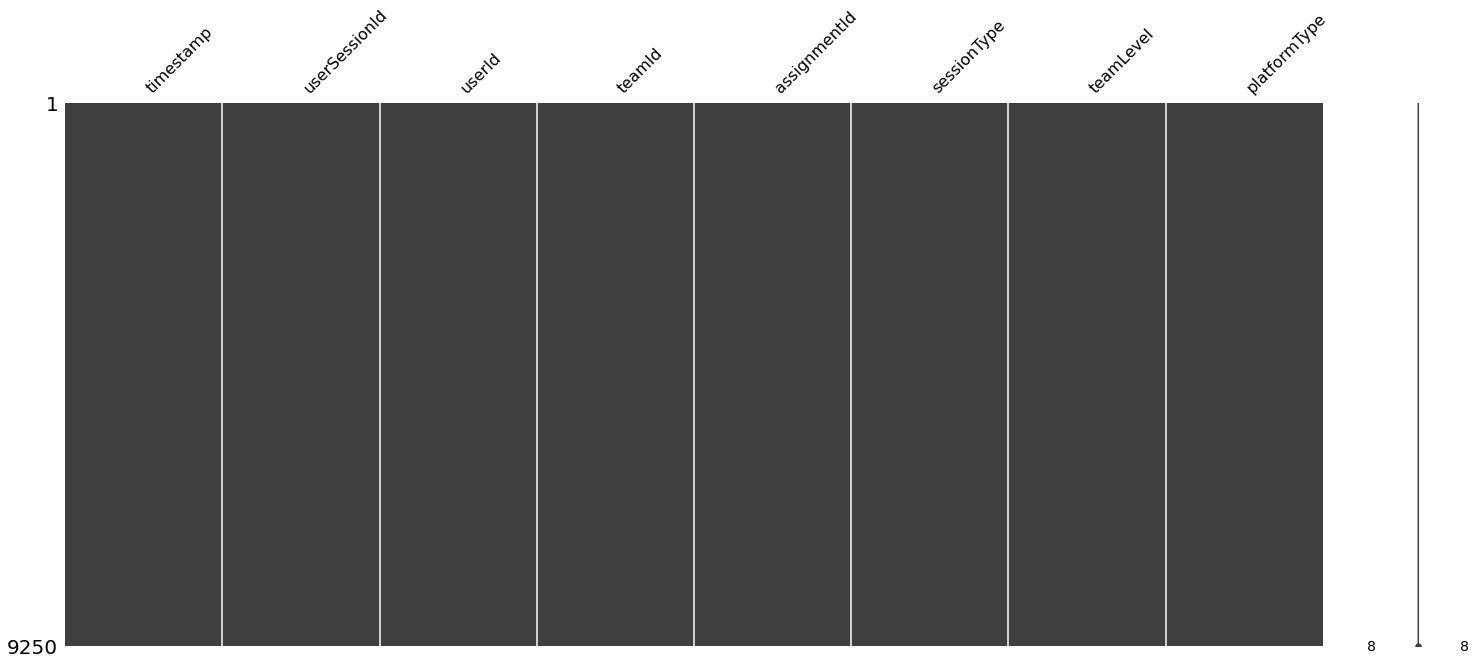

In [38]:
msno.matrix(data_loaded["user_session_pd"])

In [39]:
generate_timeseries_plot(data_frame = data_loaded["user_session_pd"], 
                         col_1="timestamp", 
                         x_label = "Date", 
                         y_label = "Test", 
                         title = "Over time",
                         file_Path = "Graphs/userSession/timeseries_userSession.png")

In [40]:
create_histogram_session(data_frame=data_loaded["user_session_pd"][["sessionType","platformType"]],
                         file_Path = "Graphs/userSession/histogram_userSession.png")

### users

In [41]:
data_loaded["users_pd"].head()

,timestamp,userId,nick,twitter,dob,country
0,1340117621,442,pcjIOBKW,@SZhyOHv,774662400,BA
1,1340134141,949,vAOfUkf,@nkkNo,41126400,HU
2,1340220899,1654,qOOXSQ,@SwOlw,9331200,IS
3,1340241509,1586,px4gW51,@IrCHTnE,-129600000,AM
4,1340292900,599,9gkfwRC73Uc,@VJj0Az,777600000,CC


<AxesSubplot:>

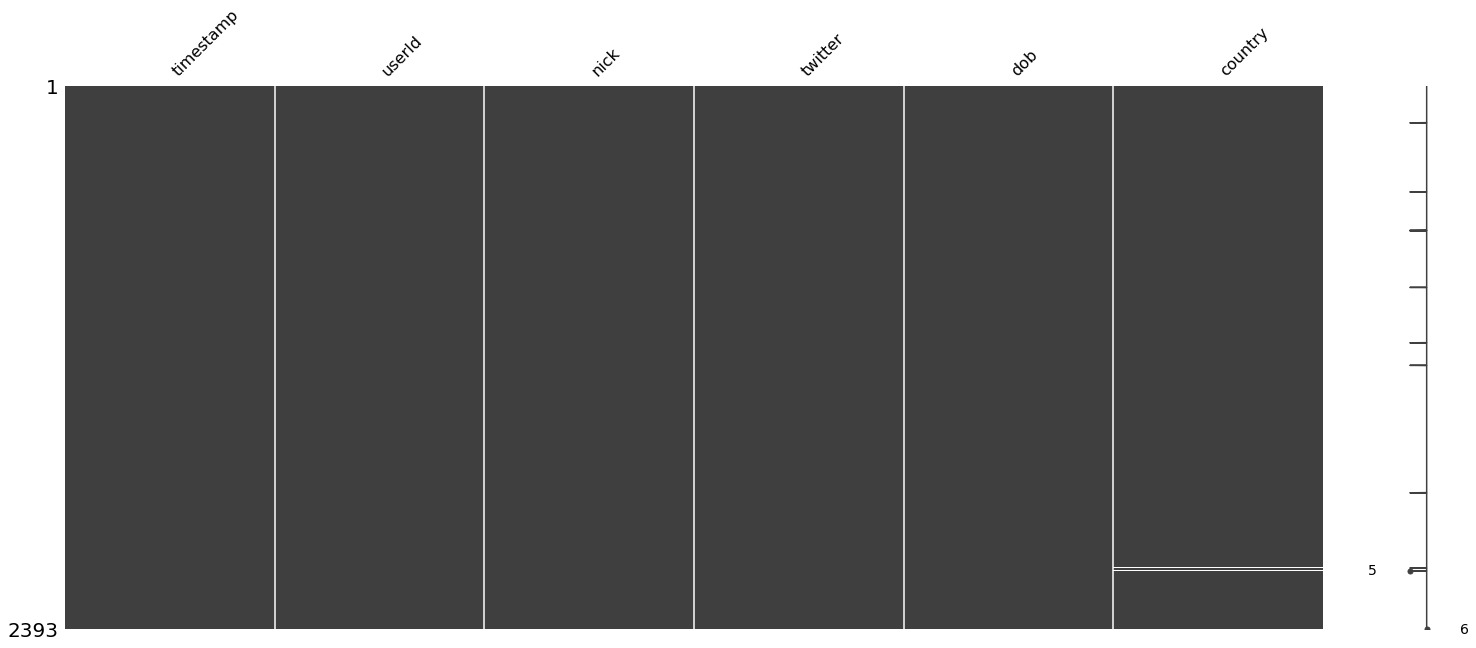

In [42]:
msno.matrix(data_loaded["users_pd"])

In [43]:
create_dob_histogram(data_frame= convert_unix_to_datetime(data_loaded["users_pd"][["dob"]], "dob")["dob"],
                     file_Path = "Graphs/users/histogram_users.png")

In [45]:
create_world_map()

## Data schema

In [46]:
schema_dict = {
    "chat-join-team-chat" : [
        StructField("user_id", IntegerType(), True),\
        StructField("teamchat_session_id", IntegerType(), True),\
        StructField("date", IntegerType(), True)
    ],
    "chat-leave-team-chat" : [
        StructField("user_id", IntegerType(), True),\
        StructField("teamchat_session_id", IntegerType(), True),\
        StructField("date", IntegerType(), True)
    ],
    "chat-mention-team-chat" : [
        StructField("chat_item", IntegerType(), True),\
        StructField("user_id", IntegerType(), True),\
        StructField("date", IntegerType(), True)
    ],
    "chat-respond-team-chat" : [
        StructField("chatid1", IntegerType(), True),\
        StructField("chatid2", IntegerType(), True),\
        StructField("date", IntegerType(), True)
    ],
    "ad-clicks" : [
        StructField("timestamp", IntegerType(), True),\
        StructField("txId", IntegerType(), True),\
        StructField("userSessionId", IntegerType(), True),\
        StructField("teamId", IntegerType(), True),\
        StructField("userId", IntegerType(), True),\
        StructField("adId", IntegerType(), True),\
        StructField("adCategory", StringType(), True)
    ],
    "buy-clicks" : [
        StructField("timestamp", IntegerType(), True),\
        StructField("txId", IntegerType(), True),\
        StructField("userSessionId", IntegerType(), True),\
        StructField("team", IntegerType(), True),\
        StructField("userId", IntegerType(), True),\
        StructField("buyId", IntegerType(), True),\
        StructField("price", DoubleType(), True)
    ],
    "game-clicks" : [
        StructField("timestamp", IntegerType(), True),\
        StructField("clickId", IntegerType(), True),\
        StructField("userId", IntegerType(), True),\
        StructField("userSessionId", IntegerType(), True),\
        StructField("isHit", StringType(), True),\
        StructField("teamId", IntegerType(), True),\
        StructField("teamLevel", IntegerType(), True)
    ],
    "level-events" : [
        StructField("timestamp", IntegerType(), True),\
        StructField("eventId", IntegerType(), True),\
        StructField("teamId", IntegerType(), True),\
        StructField("teamLevel", IntegerType(), True),\
        StructField("eventType", StringType(), True)
    ],
    "team-assignments" : [
        StructField("timestamp", IntegerType(), True),\
        StructField("team", IntegerType(), True),\
        StructField("userId", IntegerType(), True),\
        StructField("assignmentId", IntegerType(), True)
    ],
    "team" : [
        StructField("teamId", IntegerType(), True),\
        StructField("name", StringType(), True),\
        StructField("teamCreationTime", IntegerType(), True),\
        StructField("teamEndTime", IntegerType(), True),\
        StructField("strength", FloatType(), True),\
        StructField("currentLevel", IntegerType(), True)
    ],
    "user-session" : [
        StructField("timestamp", IntegerType(), True),\
        StructField("userSessionId", IntegerType(), True),\
        StructField("userId", IntegerType(), True),\
        StructField("teamId", IntegerType(), True),\
        StructField("assignmentId", IntegerType(), True),\
        StructField("sessionType", StringType(), True),\
        StructField("teamLevel", IntegerType(), True),\
        StructField("platformType", StringType(), True)
    ],
    "users" : [
        StructField("timestamp", IntegerType(), True),\
        StructField("userId", IntegerType(), True),\
        StructField("nick", StringType(), True),\
        StructField("twitter", StringType(), True),\
        StructField("dob", IntegerType(), True),\
        StructField("country", StringType(), True)
    ],
    "combined-data" : [
        StructField("userId", IntegerType(), True),\
        StructField("userSessionId", IntegerType(), True),\
        StructField("teamLevel", IntegerType(), True),\
        StructField("platformType", StringType(), True),\
        StructField("count_gameclicks", IntegerType(), True),\
        StructField("count_hits", IntegerType(), True),\
        StructField("count_buyId", StringType(), True),\
        StructField("avg_price", StringType(), True)
    ]
}

## Load data

In [47]:
data_chat_join_team_chat = spark.createDataFrame(
                              data_loaded["chat_join_team_chat_pd"], 
                              schema=StructType(schema_dict["chat-join-team-chat"])
                              )

data_chat_leave_team_chat = spark.createDataFrame(
                              data_loaded["chat_leave_team_chat_pd"], 
                              schema=StructType(schema_dict["chat-leave-team-chat"])
                              )

data_chat_mention_team_chat = spark.createDataFrame(
                              data_loaded["chat_mention_team_chat_pd"], 
                              schema=StructType(schema_dict["chat-mention-team-chat"])
                              )

data_chat_respond_team_chat = spark.createDataFrame(
                              data_loaded["chat_respond_team_chat_pd"], 
                              schema=StructType(schema_dict["chat-respond-team-chat"])
                              )

data_ad_clicks = spark.createDataFrame(
                              data_loaded["ad_clicks_pd"], 
                              schema=StructType(schema_dict["ad-clicks"])
                              )

data_buy_clicks = spark.createDataFrame(
                              data_loaded["buy_clicks_pd"], 
                              schema=StructType(schema_dict["buy-clicks"])
                              )

data_game_clicks = spark.createDataFrame(
                              data_loaded["game_clicks_pd"], 
                              schema=StructType(schema_dict["game-clicks"])
                              )

data_level_events = spark.createDataFrame(
                              data_loaded["level_events_pd"], 
                              schema=StructType(schema_dict["level-events"])
                              )

data_team_assignments = spark.createDataFrame(
                              data_loaded["team_assignments_pd"], 
                              schema=StructType(schema_dict["team-assignments"])
                              )

data_team = spark.createDataFrame(
                              data_loaded["team_pd"],
                              schema=StructType(schema_dict["team"])
                              )
                
data_user_session = spark.createDataFrame(
                              data_loaded["user_session_pd"], 
                              schema=StructType(schema_dict["user-session"])
                              )

data_users = spark.createDataFrame(
                              data_loaded["users_pd"], 
                              schema=StructType(schema_dict["users"])
                              )

data_combined_data = spark.createDataFrame(
                              data_loaded["combined_data_pd"], 
                              schema=StructType(schema_dict["combined-data"])
                              )


# Data transformation

In [48]:
def replace_value(df, column, to_replace, replace_with):
  return df.withColumn(column, regexp_replace(col(column), to_replace, replace_with))

def change_datatype(df, column, data_type):
  return df.withColumn(column, col(column).cast(data_type))

In [49]:
data_combined_data = replace_value(data_combined_data, "count_buyId", "NaN", "null")
data_combined_data = change_datatype(data_combined_data, "count_buyId", "double")

data_combined_data = replace_value(data_combined_data, "avg_price", "NaN", "null")
data_combined_data = change_datatype(data_combined_data, "avg_price", "double")

data_game_clicks = replace_value(data_game_clicks, "isHit", "0", "False")
data_game_clicks = replace_value(data_game_clicks, "isHit", "1", "True")
data_game_clicks = change_datatype(data_game_clicks, "isHit", "boolean")

# Join dataframes

## Mega frame

In [50]:
from pyspark.sql import functions as F
mega_dataframe = data_users.select("userId","nick","twitter", from_unixtime("dob", "yyyy-MM-dd").alias("dob"),"country")\
                .join(data_user_session.select("userId","teamId","platformType"), ["userId"], 'right')\
                .join(data_team.select("teamId","name","strength"), ["teamId"], 'left')\
                .join(data_ad_clicks.select("userId","adId","adCategory"), ["userId"], 'full')\
                .dropDuplicates()\
                .fillna({
                         "strength":0
                         })
mega_dataframe = mega_dataframe.select( *[ F.when(F.col(column).isNull(),'').otherwise(F.col(column)).alias(column) for column in mega_dataframe.columns])                    
#mega_dataframe.show()

## Ads frame

In [51]:
ad_dataframe = data_ad_clicks.select("teamId","userId","adId","adCategory")\
                .join(data_buy_clicks.select("team","userId","price"), ["userId"], 'full')\
                .join(data_users.select("userId","country"), ["userId"], 'full')\
                .dropDuplicates()\
                .fillna({
                         "teamId":0,
                         "adId":999,
                         "team":999,
                         "price":0
                         })
ad_dataframe = ad_dataframe.select( *[ F.when(F.col(column).isNull(),'').otherwise(F.col(column)).alias(column) for column in ad_dataframe.columns])                
#ad_dataframe.show()

## Double check nulls in columns

In [52]:
sc = SparkContext.getOrCreate()
sql = SQLContext(sc)

def calc_null_percent(spark_df,sort=True):
    pd_col_count = spark_df.select([F.count(F.col(c)).alias(c) 
                                        for (c,c_type) in spark_df.dtypes]
                                  ).toPandas().T.reset_index().rename(columns={0: 'total_count'
                                                                               ,'index':'column'})
    
    pd_col_null_count = spark_df.select([F.sum(F.when(F.isnan(c) | F.isnull(c),1).otherwise(0)).alias(c)
                                         for (c,c_type) in spark_df.dtypes]
                                       ).toPandas().T.reset_index().rename(columns={0: 'null_count'
                                                                                    ,'index':'column'})
    
    final_df = pd.merge(pd_col_count,pd_col_null_count,on=['column'])
    
    final_df['null_percentage'] = final_df['null_count'] * 100 / final_df['total_count']

    if len(final_df) == 0:
        print("There are no any missing values!")
        return None

    return final_df

/Users/zanzver/opt/anaconda3/lib/python3.8/site-packages/pyspark/sql/context.py:112: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



In [ ]:
nullStatsDF = sql.createDataFrame(calc_null_percent(mega_dataframe))

nullStatsDF.show()

nullStatsDF = sql.createDataFrame(calc_null_percent(ad_dataframe))

nullStatsDF.show()

# Insert data into Neo4j

## Functions

In [ ]:
def get_creds(port_end):
    return f"bolt://localhost:768{port_end}", "neo4j", "password"

def create_user_sessions(data_chat_join_team_chat, data_chat_leave_team_chat, data_chat_mention_team_chat, data_chat_respond_team_chat):
    # Connect to Neo4j instance
    uri, user, password = get_creds(0)
    driver = GraphDatabase.driver(uri, auth=(user, password))

    # Define Cypher queries
    create_user_query = "CREATE (:User {id: $user_id})"
    create_teamchat_session_query = "CREATE (:TeamchatSession {id: $teamchat_session_id, date: $date})"
    create_chat_item_query = "CREATE (:ChatItem {id: $chat_item})"
    create_chat_relation_query = "MATCH (c1), (c2) WHERE c1.id = $chatid1 AND c2.id = $chatid2 CREATE (c1)-[:RESPONDS_TO]->(c2)"
    create_mention_relation_query = "MATCH (u), (c) WHERE u.id = $user_id AND c.id = $chat_item CREATE (u)-[:MENTIONS]->(c)"
    create_join_relation_query = "MATCH (u), (t) WHERE u.id = $user_id AND t.id = $teamchat_session_id CREATE (u)-[:JOINS]->(t)"
    create_leave_relation_query = "MATCH (u), (t) WHERE u.id = $user_id AND t.id = $teamchat_session_id CREATE (u)-[:LEAVES]->(t)"

    # Define list of queries and parameters to execute
    queries = [
        (create_user_query, data_chat_join_team_chat.select("user_id").distinct()),
        (create_teamchat_session_query, data_chat_join_team_chat.select("teamchat_session_id", "date").distinct()),
        (create_chat_item_query, data_chat_mention_team_chat.select("chat_item").distinct()),
        (create_chat_relation_query, data_chat_respond_team_chat.select("chatid1", "chatid2")),
        (create_mention_relation_query, data_chat_mention_team_chat.select("user_id", "chat_item")),
        (create_join_relation_query, data_chat_join_team_chat.select("user_id", "teamchat_session_id")),
        (create_leave_relation_query, data_chat_leave_team_chat.select("user_id", "teamchat_session_id"))
    ]

    # Execute queries
    with driver.session() as session:
        for query, data in queries:
            for row in data.collect():
                session.run(query, **row.asDict())
                
def create_msg_between_users(data_chat_join_team_chat, data_chat_leave_team_chat, data_chat_mention_team_chat, data_chat_respond_team_chat):
    # Connect to Neo4j instance
    uri, user, password = get_creds(1)
    driver = GraphDatabase.driver(uri, auth=(user, password))

    # Define Cypher queries
    create_user_query = "MERGE (:User {id: $user_id})"
    create_teamchat_session_query = "MERGE (:TeamchatSession {id: $teamchat_session_id, date: $date})"
    create_chat_item_query = "MERGE (:ChatItem {id: $chat_item})"
    create_chat_relation_query = """
        MATCH (c1), (c2) 
        WHERE c1.id = $chatid1 AND c2.id = $chatid2 
        AND c1.user_id <> c2.user_id 
        CREATE (c1)-[:RESPONDS_TO]->(c2)
    """
    create_mention_relation_query = "MATCH (u), (c) WHERE u.id = $user_id AND c.id = $chat_item CREATE (u)-[:MENTIONS]->(c)"
    create_join_relation_query = "MATCH (u), (t) WHERE u.id = $user_id AND t.id = $teamchat_session_id CREATE (u)-[:JOINS]->(t)"
    create_leave_relation_query = "MATCH (u), (t) WHERE u.id = $user_id AND t.id = $teamchat_session_id CREATE (u)-[:LEAVES]->(t)"
    create_send_relation_query = "MATCH (u), (c), (t) WHERE u.id = $user_id AND c.id = $chat_item AND t.id = $teamchat_session_id CREATE (u)-[:SENDS]->(c)-[:IN]->(t)"

    # Define list of queries and parameters to execute
    queries = [
        (create_user_query, data_chat_join_team_chat.select("user_id").distinct()),
        (create_teamchat_session_query, data_chat_join_team_chat.select("teamchat_session_id", "date").distinct()),
        (create_chat_item_query, data_chat_mention_team_chat.select("chat_item").distinct()),
        (create_chat_relation_query, data_chat_respond_team_chat.select("chatid1", "chatid2")),
        (create_mention_relation_query, data_chat_mention_team_chat.select("user_id", "chat_item")),
        (create_join_relation_query, data_chat_join_team_chat.select("user_id", "teamchat_session_id")),
        (create_leave_relation_query, data_chat_leave_team_chat.select("user_id", "teamchat_session_id")),
        (create_send_relation_query, data_chat_mention_team_chat.join(data_chat_join_team_chat, ["user_id"]).join(data_chat_leave_team_chat, ["user_id", "teamchat_session_id"]).select("user_id", "chat_item", "teamchat_session_id"))
    ]

    # Execute queries
    with driver.session() as session:
        for query, data in queries:
            for row in data.collect():
                session.run(query, **row.asDict())

def create_mega_graph(mega_dataframe):
    # Connect to Neo4j instance
    uri, user, password = get_creds(2)
    driver = GraphDatabase.driver(uri, auth=(user, password))

    # Define Cypher queries
    create_user_query = "MERGE (:User {id: $userId})"
    create_country_query = "MERGE (:Country {name: $country})"
    create_team_query = "MERGE (:Team {id: $teamId, name: $name})"
    create_platform_query = "MERGE (:PlatformType {name: $platformType})"
    create_ad_query = "MERGE (:Ad {id: $adId})"
    create_category_query = "MERGE (:AdCategory {name: $adCategory})"
    create_country_user_rel_query = "MATCH (u:User), (c:Country) WHERE u.id = $userId AND c.name = $country CREATE (u)-[:BELONGS_TO_COUNTRY]->(c)"
    create_team_user_rel_query = "MATCH (u:User), (t:Team) WHERE u.id = $userId AND t.id = $teamId CREATE (u)-[:MEMBER_OF_TEAM {strength: $strength}]->(t)"
    create_platform_user_rel_query = "MATCH (u:User), (p:PlatformType) WHERE u.id = $userId AND p.name = $platformType CREATE (u)-[:USES_PLATFORM]->(p)"
    create_ad_user_rel_query = "MATCH (u:User), (a:Ad) WHERE u.id = $userId AND a.id = $adId CREATE (u)-[:VIEWED_AD]->(a)"
    create_category_ad_rel_query = "MATCH (a:Ad), (c:AdCategory) WHERE a.id = $adId AND c.name = $adCategory CREATE (a)-[:BELONGS_TO_CATEGORY]->(c)"

    # Define list of queries and parameters to execute
    queries = [
        (create_user_query, mega_dataframe.select("userId").distinct()),
        (create_country_query, mega_dataframe.select("country").distinct()),
        (create_team_query, mega_dataframe.select("teamId", "name").distinct()),
        (create_platform_query, mega_dataframe.select("platformType").distinct()),
        (create_ad_query, mega_dataframe.select("adId").distinct()),
        (create_category_query, mega_dataframe.select("adCategory").distinct()),
        (create_country_user_rel_query, mega_dataframe.select("userId", "country")),
        (create_team_user_rel_query, mega_dataframe.select("userId", "teamId", "strength", "name")),
        (create_platform_user_rel_query, mega_dataframe.select("userId", "platformType")),
        (create_ad_user_rel_query, mega_dataframe.select("userId", "adId")),
        (create_category_ad_rel_query, mega_dataframe.select("adId", "adCategory"))
    ]

    # Execute queries
    with driver.session() as session:
        for query, data in queries:
            for row in data.collect():
                session.run(query, **row.asDict())

def create_ad_graph(ad_dataframe):
    # Connect to Neo4j instance
    uri, user, password = get_creds(3)
    driver = GraphDatabase.driver(uri, auth=(user, password))

    # Define Cypher queries
    create_user_query = "MERGE (:User {id: $userId})"
    create_country_query = "MERGE (:Country {name: $country})"
    create_team_query = "MERGE (:Team {id: $teamId, name: $team, price: $price})"
    create_ad_query = "MERGE (:Ad {id: $adId, category: $adCategory})"
    create_user_country_relation_query = "MATCH (u:User), (c:Country) WHERE u.id = $userId AND c.name = $country CREATE (u)-[:LIVES_IN]->(c)"
    create_user_team_relation_query = "MATCH (u:User), (t:Team) WHERE u.id = $userId AND t.id = $teamId CREATE (u)-[:SUPPORTS]->(t)"
    create_team_ad_relation_query = "MATCH (t:Team), (a:Ad) WHERE t.id = $teamId AND a.id = $adId CREATE (t)-[:SHOWS]->(a)"

    # Define list of queries and parameters to execute
    queries = [
        (create_user_query, ad_dataframe.select("userId").distinct()),
        (create_country_query, ad_dataframe.select("country").distinct()),
        (create_team_query, ad_dataframe.select("teamId", "team", "price").distinct()),
        (create_ad_query, ad_dataframe.select("adId", "adCategory").distinct()),
        (create_user_country_relation_query, ad_dataframe.select("userId", "country")),
        (create_user_team_relation_query, ad_dataframe.select("userId", "teamId")),
        (create_team_ad_relation_query, ad_dataframe.select("teamId", "adId"))
    ]

    # Execute queries
    with driver.session() as session:
        for query, data in queries:
            for row in data.collect():
                session.run(query, **row.asDict())

## Create graphs

### User sessions

In [ ]:
create_user_sessions(data_chat_join_team_chat.limit(500), 
                     data_chat_leave_team_chat.limit(500), 
                     data_chat_mention_team_chat.limit(500), 
                     data_chat_respond_team_chat.limit(500))

### Messages between users

In [ ]:
create_msg_between_users(data_chat_join_team_chat.limit(500), 
                         data_chat_leave_team_chat.limit(500), 
                         data_chat_mention_team_chat.limit(500), 
                         data_chat_respond_team_chat.limit(500))

### Mega dataframe graph

In [ ]:
create_mega_graph(mega_dataframe.limit(1000))

### Ad graph

In [ ]:
create_ad_graph(ad_dataframe.limit(1000))

# ML

## Classification

In [53]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import pandas as pd
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def split_data(df):
    indexer = StringIndexer(inputCol="platformType", outputCol="label")
    df = indexer.fit(df).transform(df)

    split_ratio = [0.8, 0.2]
    seed = 42
    train_data, test_data = df.randomSplit(split_ratio, seed=seed)

    x_train = train_data.select("platformType").toPandas()
    y_train = train_data.select("label").toPandas()

    x_test = test_data.select("platformType").toPandas()
    y_test = test_data.select("label").toPandas()

    return x_train, x_test, y_train, y_test

def build_decision_tree_model(x_train, y_train):
    train_data = spark.createDataFrame(pd.concat([x_train, y_train], axis=1))

    platform_indexer = StringIndexer(inputCol="platformType", outputCol="platformIndex")
    train_data = platform_indexer.fit(train_data).transform(train_data)

    assembler = VectorAssembler(inputCols=["platformIndex"], outputCol="features")
    train_data = assembler.transform(train_data)

    dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")

    # Create a parameter grid for hyperparameter tuning
    paramGrid = ParamGridBuilder() \
        .addGrid(dt.maxDepth, [2, 4, 6]) \
        .addGrid(dt.minInstancesPerNode, [1, 2, 4]) \
        .build()

    # Create cross-validator
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

    # Fit the model with cross-validation
    cvModel = crossval.fit(train_data)

    return cvModel.bestModel

def build_svm_model(x_train, y_train):
    train_data = spark.createDataFrame(pd.concat([x_train, y_train], axis=1))

    platform_indexer = StringIndexer(inputCol="platformType", outputCol="indexedLabel")
    train_data = platform_indexer.fit(train_data).transform(train_data)

    assembler = VectorAssembler(inputCols=["indexedLabel"], outputCol="features")
    train_data = assembler.transform(train_data)

    svm = LinearSVC(featuresCol="features", labelCol="indexedLabel")

    # Create a parameter grid for hyperparameter tuning
    paramGrid = ParamGridBuilder() \
        .addGrid(svm.maxIter, [10, 100]) \
        .addGrid(svm.regParam, [0.1, 0.01]) \
        .build()

    # Create OneVsRest classifier
    ovr = OneVsRest(classifier=svm)

    # Create cross-validator
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=ovr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

    # Fit the model with cross-validation
    cvModel = crossval.fit(train_data)

    return cvModel.bestModel

def evaluate_model(model, x_test, y_test, file_Path):
    test_data = spark.createDataFrame(pd.concat([x_test, y_test], axis=1))

    platform_indexer = StringIndexer(inputCol="platformType", outputCol="platformIndex")
    test_data = platform_indexer.fit(test_data).transform(test_data)

    assembler = VectorAssembler(inputCols=["platformIndex"], outputCol="features")
    test_data = assembler.transform(test_data)

    predictions = model.transform(test_data)

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

    # Calculate metrics for each class
    class_labels = test_data.select("label").distinct().rdd.flatMap(lambda x: x).collect()
    metrics = {}

    for label in class_labels:
        evaluator.setMetricName("accuracy")
        evaluator.setMetricLabel(label)
        accuracy = evaluator.evaluate(predictions)

        evaluator.setMetricName("weightedPrecision")
        evaluator.setMetricLabel(label)
        precision = evaluator.evaluate(predictions)

        evaluator.setMetricName("weightedRecall")
        evaluator.setMetricLabel(label)
        recall = evaluator.evaluate(predictions)

        evaluator.setMetricName("weightedFMeasure")
        evaluator.setMetricLabel(label)
        f1_score = evaluator.evaluate(predictions)

        metrics[label] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1-score": f1_score}

    predictionAndLabels = predictions.select("prediction", "label").rdd
    multiclass_metrics = MulticlassMetrics(predictionAndLabels)
    confusion_matrix = multiclass_metrics.confusionMatrix().toArray()

    label_counts = predictionAndLabels.map(lambda x: (x[1], 1)).reduceByKey(lambda x, y: x + y).collectAsMap()
    support = {label: label_counts.get(label, 0) for label in class_labels}

    # Print Metrics per Class as a Table
    metrics_table = pd.DataFrame.from_dict(metrics, orient="index")
    print("Metrics per Class:")
    print(metrics_table)

    # Print Support as a Table
    support_table = pd.DataFrame.from_dict(support, orient="index", columns=["Support"])
    print("Support:")
    print(support_table)

    # Plot Confusion Matrix
    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix, cmap="Blues")

    # Create tick labels
    tick_labels = np.arange(len(class_labels))
    ax.set_xticks(tick_labels)
    ax.set_yticks(tick_labels)
    ax.set_xticklabels(class_labels, rotation=45)
    ax.set_yticklabels(class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Count", rotation=-90, va="bottom")

    # Add value annotations
    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            text = ax.text(j, i, int(confusion_matrix[i, j]), ha="center", va="center", color="w")

    plt.title("Confusion Matrix")
    
    # Save the metrics and confusion matrix plots to the specified file path
    metrics_table.to_csv(file_Path + "/metrics.csv")
    plt.savefig(file_Path + "/confusion_matrix.png")

    # Close the figure to free up resources
    plt.close()


In [54]:
x_train, x_test, y_train, y_test = split_data(mega_dataframe)

dt_model = build_decision_tree_model(x_train, y_train)

svm_model = build_svm_model(x_train, y_train)

In [55]:
evaluate_model(dt_model, x_test, y_test, file_Path = "Models/Classification/DecisionTree")

/Users/zanzver/opt/anaconda3/lib/python3.8/site-packages/pyspark/sql/context.py:157: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



Metrics per Class:
     accuracy  precision  recall  f1-score
0.0       1.0        1.0     1.0       1.0
1.0       1.0        1.0     1.0       1.0
4.0       1.0        1.0     1.0       1.0
3.0       1.0        1.0     1.0       1.0
2.0       1.0        1.0     1.0       1.0
5.0       1.0        1.0     1.0       1.0
Support:
     Support
0.0      830
1.0      696
4.0       62
3.0      122
2.0      264
5.0       34


In [56]:

evaluate_model(svm_model, x_test, y_test, file_Path = "Models/Classification/SVM")

/Users/zanzver/opt/anaconda3/lib/python3.8/site-packages/pyspark/sql/context.py:157: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



Metrics per Class:
     accuracy  precision    recall  f1-score
0.0  0.575697   0.465366  0.575697  0.489153
1.0  0.575697   0.465366  0.575697  0.489153
4.0  0.575697   0.465366  0.575697  0.489153
3.0  0.575697   0.465366  0.575697  0.489153
2.0  0.575697   0.465366  0.575697  0.489153
5.0  0.575697   0.465366  0.575697  0.489153
Support:
     Support
0.0      830
1.0      696
4.0       62
3.0      122
2.0      264
5.0       34


## Clustering

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import GaussianMixture
from pyspark.sql.functions import col
from pyspark.ml.evaluation import ClusteringEvaluator

def train_test_split(dataframe, test_ratio=0.2):
    # Convert the 'strength' column to a numerical data type
    dataframe = dataframe.withColumn('strength', col('strength').cast('double'))

    # Split the data into training and testing sets
    train_df, test_df = dataframe.randomSplit([1 - test_ratio, test_ratio], seed=42)

    return train_df, test_df

def create_kmeans_model(train_df, test_df, k):
    # Create a VectorAssembler to combine features into a single vector column
    assembler = VectorAssembler(inputCols=['strength'], outputCol='features')

    # Assemble the features for training data
    x_train = assembler.transform(train_df).select('features')

    # Assemble the features for testing data
    x_test = assembler.transform(test_df).select('features')

    # Create a KMeans instance with the given k value
    kmeans = KMeans(k=k, seed=42)

    # Fit the model on the training data
    model = kmeans.fit(x_train)

    # Make predictions on the testing data
    predictions = model.transform(x_test)

    return predictions

def create_gmm_model(train_df, test_df, k):
    # Create a VectorAssembler to combine features into a single vector column
    assembler = VectorAssembler(inputCols=['strength'], outputCol='features')

    # Assemble the features for training data
    x_train = assembler.transform(train_df).select('features')

    # Assemble the features for testing data
    x_test = assembler.transform(test_df).select('features')

    # Create a KMeans instance with the given k value
    gmm = GaussianMixture(k=k, seed=42)

    # Fit the model on the training data
    model = gmm.fit(x_train)

    # Make predictions on the testing data
    predictions = model.transform(x_test)

    return predictions

def evaluate_kmeans_model(train_df, test_df, max_k, file_Path):
    # Store the Silhouette scores for different k values
    silhouette_scores = []

    for k in range(2, max_k + 1):
        # Predict platform type using the given k value
        predictions = create_kmeans_model(train_df, test_df, k)

        # Evaluate the clustering model using Silhouette score
        evaluator = ClusteringEvaluator()

        # Calculate the Silhouette score
        silhouette = evaluator.evaluate(predictions)

        silhouette_scores.append(silhouette)

    # Plot the Silhouette scores
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. Number of Clusters')

    # Save the plot to the specified file path
    plt.savefig(file_Path)

    # Close the plot
    plt.close()



def evaluate_gmm_model(train_df, test_df, max_k, file_Path):
    # Store the Silhouette scores for different k values
    silhouette_scores = []

    for k in range(2, max_k + 1):
        # Predict platform type using the given k value
        predictions = create_gmm_model(train_df, test_df, k)

        # Evaluate the clustering model using Silhouette score
        evaluator = ClusteringEvaluator()

        # Calculate the Silhouette score
        silhouette = evaluator.evaluate(predictions)

        silhouette_scores.append(silhouette)

    # Plot the Silhouette scores
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. Number of Clusters')

    # Save the plot to the specified file path
    plt.savefig(file_Path)

    # Close the plot
    plt.close()


# Assuming 'df' is your input DataFrame
train_df, test_df = train_test_split(mega_dataframe)

# Assuming 'df' is your input DataFrame
train_df, test_df = train_test_split(mega_dataframe)

# Evaluate the clustering model and plot the graph
#evaluate_model(train_df, test_df, 10, 10)
evaluate_kmeans_model(train_df, test_df, 50, file_Path = "Models/Clustering/kmenas")
evaluate_gmm_model(train_df, test_df, 200, file_Path = "Models/Clustering/gmm")


# Testing

In [ ]:
data_chat_join_team_chat.show()
data_chat_join_team_chat.printSchema()

data_chat_leave_team_chat.show()
data_chat_leave_team_chat.printSchema()

data_chat_mention_team_chat.show()
data_chat_mention_team_chat.printSchema()

data_chat_respond_team_chat.show()
data_chat_respond_team_chat.printSchema()

data_ad_clicks.show()
data_ad_clicks.printSchema()

data_buy_clicks.show()
data_buy_clicks.printSchema()

data_combined_data.show()
data_combined_data.printSchema()

data_game_clicks.show()
data_game_clicks.printSchema()

data_level_events.show()
data_level_events.printSchema()

data_team_assignments.show()
data_team_assignments.printSchema()

data_team.show()
data_team.printSchema()

data_user_session.show()
data_user_session.printSchema()

data_users.show()
data_users.printSchema()

In [ ]:


#joined_df = data_ad_clicks.join(data_buy_clicks, data_ad_clicks.userId == data_buy_clicks.userId, 'full')
#joined_df.show()